In [11]:
import keras.layers as layers
import matplotlib.pyplot as plt
from keras import Model
from numpy import argmax
from keras.optimizers import SGD, Adam
from pandas import read_csv
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
from keras.models import Sequential
from keras.utils import to_categorical
import os
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator # In Colab, change to keras.preprocessing.image import ImageDataGenerator
import numpy as np
from PIL import Image
from sklearn.utils.class_weight import compute_class_weight

# CONSTANTS
IMAGE_SIZE=(224,224) # images will be resized to this
ALPHA=0.001 # learning rate
BATCH_SIZE=32 # batch size for training
NUM_EPOCHS=5 # number of iterations over training data during training

def prepare_data():
    """
    Prepares the data generators for training, validation, and testing datasets.
    
    The function creates a DataFrame with image paths and labels, splits the data into
    training and testing sets, and generates data batches for the training, validation,
    and testing processes. Images are resized and normalized.

    Returns:
        train (DirectoryIterator): Data generator for the training set.
        val (DirectoryIterator): Data generator for the validation set.
        test (DirectoryIterator): Data generator for the testing set.
    """
    # Create df with image paths and labels 
    image_dir = Path("new-reptiles-and-amphibians-image-dataset")
    filepaths = list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png'))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    image_df = pd.concat([filepaths, labels], axis=1) # 5994 rows, 2 cols

    # Split data into training and testing sets
    train_df, test_df = train_test_split(image_df, test_size=0.2, stratify=image_df['Label'], random_state=12)

    # Create data generators for training, validation, and testing sets; generators load images from the file paths, resize them, normalize pixel values, and handle batch processing of images
    train_generator = ImageDataGenerator(
        rescale=1./255, # Normalize pixel values from 0-255 to 0-1
        validation_split=0.2 # 20% of training data will be used as validation
        #shear_range=0.2,
        #zoom_range=0.2,
        #horizontal_flip=True
    )
    test_generator = ImageDataGenerator(
        rescale=1./255
    )
    train = train_generator.flow_from_dataframe(
      dataframe=train_df,
      x_col='Filepath',
      y_col='Label',
      target_size=IMAGE_SIZE, # Resize all images to size 224x224
      color_mode='rgb',
      class_mode='binary', # Use binary labels (0,1)
      batch_size=BATCH_SIZE,
      #shuffle=True,
      #seed=8,
      subset='training'
    )
    val = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=IMAGE_SIZE,
        color_mode='rgb',
        class_mode='binary',
        batch_size=BATCH_SIZE,
        #shuffle=False,
        subset='validation'
    )
    test = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=IMAGE_SIZE,
        color_mode='rgb',
        class_mode='binary',
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    return train, val, test

def show_images(generator, type):
    """
      Display 3 reptile and 3 amphibian images from the given generator, along with their sizes.
      
      Args:
          generator (DirectoryIterator): The data generator to get images from.
          type (str): The data source (train, test, val) to plot images from.
    """
    # Map class labels to names
    class_names = {0: 'amphibian', 1: 'reptile'}

    # Get next batch of images and labels from the generator
    images, labels = next(generator)
      
    # Get indices of first 3 reptile and amphibian images 
    reptile_indices = [i for i, label in enumerate(labels) if label == 1]
    amphibian_indices = [i for i, label in enumerate(labels) if label == 0]
    selected_reptile_indices = reptile_indices[:3]
    selected_amphibian_indices = amphibian_indices[:3]
    selected_indices = selected_reptile_indices + selected_amphibian_indices
      
    # Loop through indices and plot the images
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(selected_indices):
        ax = plt.subplot(1, 6, i + 1)
        plt.imshow(images[idx])
        label_index = labels[idx]
        image_size = images[idx].shape[:2]  # Get the height and width of the image
        plt.title(f"{class_names[label_index]}\n{image_size[0]}x{image_size[1]}")
        plt.axis("off")
    print(f"Image examples for {type}:")
    plt.show()

    # Reset generator to ensure no data is skipped during training
    generator.reset()

    return

def build_and_compile_cnn():
    """
    Build and compile a Convolutional Neural Network model.

    The CNN consists of:
    - Three convolutional layers with ReLU activation and max pooling layers.
    - A flattening layer to convert 2D matrices into a 1D vector.
    - A dense (fully connected) layer with ReLU activation.
    - A dropout layer to prevent overfitting.
    - A dense output layer with sigmoid activation for binary classification.

    The model is compiled using the RMSProp optimizer and binary cross-entropy loss.

    Returns:
        model (Sequential): The compiled CNN model.
    """
    # Initialize a sequential model
    model = Sequential([
        # 1: convolutional layer with 32 filters of size 3x3, ReLU activation, and a max pooling layer with window size 2x2
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        layers.MaxPooling2D((2, 2)),
        # 2: convolutional layer with 64 filters of size 3x3, ReLU activation, and a max pooling layer with window size 2x2
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        # 3: convolutional layer with 64 filters of size 3x3, ReLU activation, and a max pooling layer with window size 2x2
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        # 4: flatten pixels of resulting image into a 1D vector
        layers.Flatten(),
        # 5: feed result into fully connected dense layer with 64 units and ReLU activation
        layers.Dense(64, activation='relu'),
        # 6: drop nodes randomly via dropout, a regularization technique used to prevent overfitting
        # layers.Dropout(0.5),
        # 7. output layer with a single unit and sigmoid activation for binary classification
        layers.Dense(1, activation='sigmoid')
    ])
    
    optimizerAdam = Adam(learning_rate=ALPHA) # RMSProp gives much better results
    # Use binary cross-entropy loss function and RMSProp optimizer
    model.compile(loss='binary_crossentropy', optimizer=optimizerAdam, metrics=['accuracy'])
    
    return model

def train_model(model, train, val):
    """
    Train the CNN model with training and validation data.

    Args:
        model (Sequential): The compiled CNN model to be trained.
        train (DirectoryIterator): The data generator for the training set.
        val (DirectoryIterator): The data generator for the validation set.
        class_weights (dict): A dictionary containing the weights for each class to handle class imbalance.

    Returns:
        history (History): The training history, which includes information about the training and validation loss and accuracy for each epoch.
    """
    # Train model on training data and validate results on validation data over a specified number of epochs, and utilize class weights to handle Amphibian image scarcity
    history = model.fit(train, validation_data=val, epochs=NUM_EPOCHS)
    
    return history

def plot_training_history(history):
    """
    Plot the training and validation accuracy over epochs.

    Args:
        history (History): The training history returned from train_model()
    """
    # Extract accuracy and validation accuracy from training history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)

    # Plot the training and validation accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    return

def evaluate_model(model, test):
    """
    Evaluate the CNN model on the test data.

    Args:
        model (Sequential): The trained CNN model to be evaluated.
        test (DirectoryIterator): The data generator for the test set.

    Returns:
        test_loss (float): The loss value for the test data.
        test_accuracy (float): The accuracy value for the test data.
    """
    # Evaluate model on test data
    test_loss, test_accuracy = model.evaluate(test)
    return test_loss, test_accuracy

def generate_confusion_matrix(model, test):
    """
    Generate predictions and create a confusion matrix for the CNN model on the test data.

    Args:
        model (Sequential): The trained CNN model to be evaluated.
        test (DirectoryIterator): The data generator for the test set.

    Returns:
        acc_score (float): The accuracy score on the test data.
        sensitivity (float): The sensitivity (recall or true positive rate) on the test data.
        specificity (float): The specificity (true negative rate) on the test data.
    """
    # Reset test data generator to ensure it is at the start
    test.reset()  

    # Get true labels from test data
    y_true = test.labels

    # Get predicted labels from test data 
    y_pred = model.predict(test)
    y_pred_classes = np.round(y_pred).astype(int).reshape(-1)

    # Compute confusion matrix and related performance metrics (accuracy, true positive rate, true negative rate)
    conf_matrix = confusion_matrix(y_true, y_pred_classes)
    acc_score = accuracy_score(y_true, y_pred_classes)
    tn, fp, fn, tp = conf_matrix.ravel()
    sensitivity = tp / (tp + fn)  
    specificity = tn / (tn + fp)  
    
    # Plot confusion matrix
    plt.figure(figsize=(5, 5))
    plt.imshow(conf_matrix, cmap=plt.cm.YlGn)
    plt.title('Confusion Matrix', fontsize=12)
    binary = [0, 1]
    plt.xticks(binary, ['Amphibian', 'Reptile'], rotation=45, fontsize=10)
    plt.yticks(binary, ['Amphibian', 'Reptile'], fontsize=10)
    thresh = conf_matrix.max() / 2.
    for i, j in np.ndindex(conf_matrix.shape):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black", fontsize=10)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=10)
    plt.xlabel('Predicted label', fontsize=10)
    plt.show()

    return acc_score, sensitivity, specificity

def plot_roc_curve(model, test):
    """
    Plot the ROC curve and compute the AUC for the CNN model on the test data.

    Args:
        model (Sequential): The trained CNN model to be evaluated.
        test (DirectoryIterator): The data generator for the test set.
    Returns:
        roc_auc (float): The AUC (Area Under the Curve) value.
    """
    # Reset the test data generator
    test.reset()
    
    # Get true labels and predicted probabilities from test data
    y_true = test.labels
    y_pred = model.predict(test).ravel()
    
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    return roc_auc

Found 3836 validated image filenames belonging to 2 classes.
Found 959 validated image filenames belonging to 2 classes.
Found 1199 validated image filenames belonging to 2 classes.
Weights for Amphibian (0) and Reptile (1) classes: {0: 2.030059271803556, 1: 0.6633923630326508}
Image examples for training set:


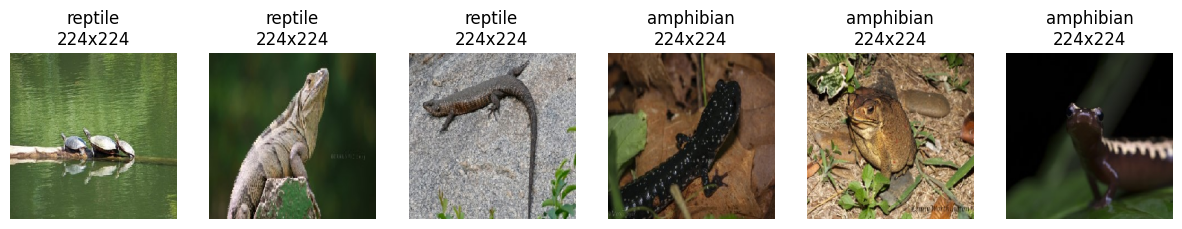

Image examples for validation set:


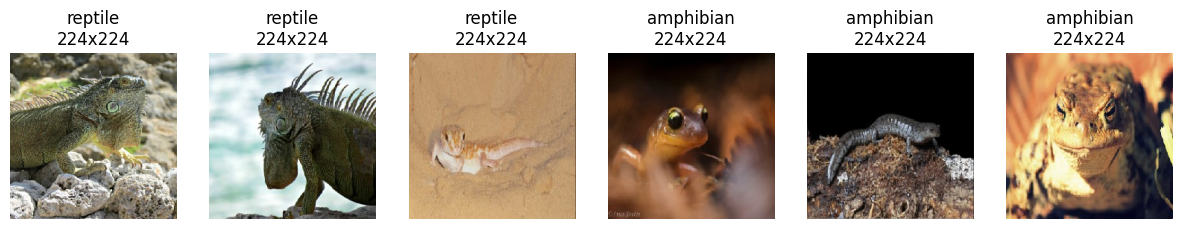

Image examples for test set:


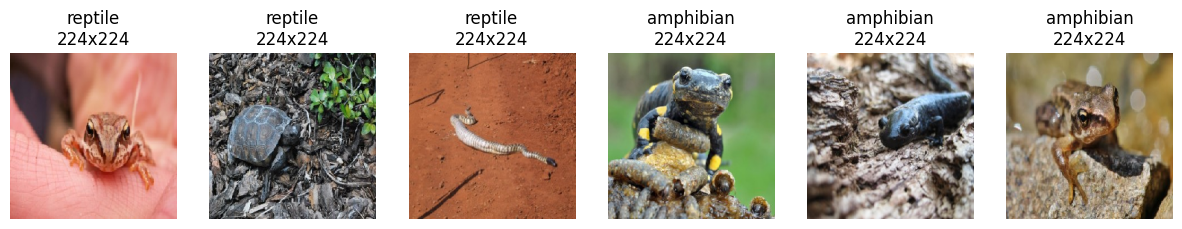

c:\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     2,768,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,825,345 (10.78 MB)

 Trainable params: 2,825,345 (10.78 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


c:\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


120/120 ━━━━━━━━━━━━━━━━━━━━ 65s 519ms/step - accuracy: 0.7526 - loss: 0.6608 - val_accuracy: 0.7487 - val_loss: 0.4852
Epoch 2/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 59s 488ms/step - accuracy: 0.7501 - loss: 0.5022 - val_accuracy: 0.8144 - val_loss: 0.4781
Epoch 3/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 60s 501ms/step - accuracy: 0.7869 - loss: 0.4593 - val_accuracy: 0.8227 - val_loss: 0.4506
Epoch 4/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 60s 498ms/step - accuracy: 0.8055 - loss: 0.4253 - val_accuracy: 0.8186 - val_loss: 0.4189
Epoch 5/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 60s 498ms/step - accuracy: 0.8363 - loss: 0.3643 - val_accuracy: 0.8123 - val_loss: 0.5090


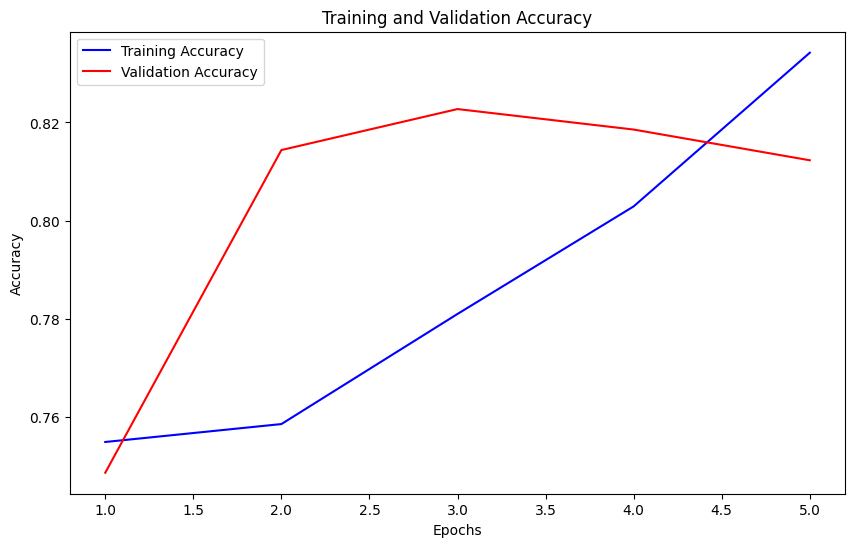

38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - accuracy: 0.7745 - loss: 0.6281
Test Accuracy: 0.7890
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step


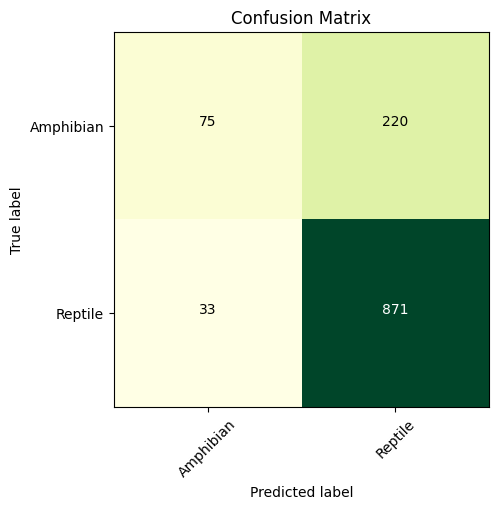

Accuracy Score: 0.7890
Sensitivity (Reptile classification accuracy): 0.9635
Specificity (Amphibian classification accuracy): 0.2542
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step


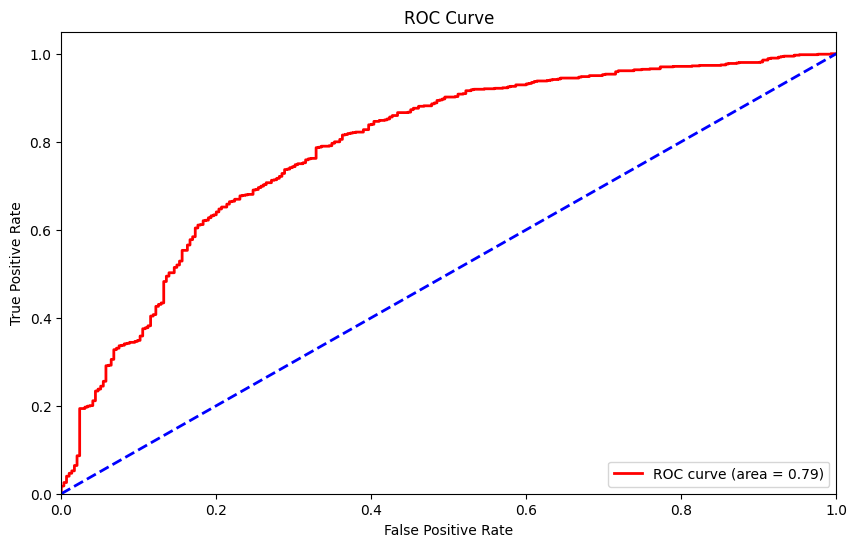

AUC: 0.7886


In [12]:
train, val, test = prepare_data()
show_images(train, "training set")
show_images(val, "validation set")
show_images(test, "test set")

model = build_and_compile_cnn()
model.summary()
history = train_model(model, train, val)
plot_training_history(history)
test_loss, test_accuracy = evaluate_model(model, test)
print(f'Test Accuracy: {test_accuracy:.4f}')

acc_score, sensitivity, specificity = generate_confusion_matrix(model, test)
print(f'Accuracy Score: {acc_score:.4f}')
print(f'Sensitivity (Reptile classification accuracy): {sensitivity:.4f}')
print(f'Specificity (Amphibian classification accuracy): {specificity:.4f}')

auc = plot_roc_curve(model, test)
print(f'AUC: {auc:.4f}')

model.save_weights('5_epochs.weights.h5')